In [59]:
# 线性回归 — 从0开始
# http://zh.gluon.ai/chapter_supervised-learning/linear-regression-scratch.html

from mxnet import ndarray as nd
from mxnet import autograd

num_inputs = 2
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

# print(nd.random_normal(shape=(num_examples, num_inputs)))

X = nd.random_normal(shape=(num_examples, num_inputs))

y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += 0.01 * nd.random_normal(shape=y.shape)

In [60]:
print(X[0], y[0])


[-1.6921576  2.0304787]
<NDArray 2 @cpu(0)> 
[-6.073694]
<NDArray 1 @cpu(0)>


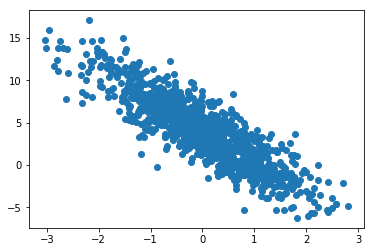

In [61]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 1].asnumpy(), y.asnumpy())
plt.ion()
plt.show()

In [62]:
import random
batch_size = 10
def data_iter():
    # 产生一个随机索引
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = nd.array(idx[i:min(i+batch_size, num_examples)])
        yield nd.take(X, j), nd.take(y, j)

In [63]:
for data, label in data_iter():
    print(data, label)
    break


[[ 0.08935784  0.19879465]
 [ 0.5973696  -2.2463048 ]
 [ 0.52908504  0.9749539 ]
 [ 1.1165185   0.40561453]
 [ 0.23048934 -1.0016762 ]
 [-0.32518476  0.1576448 ]
 [ 0.5511009  -2.7435234 ]
 [ 0.06650884 -0.9181457 ]
 [-1.2596394   0.48891923]
 [-1.4992427  -0.90919566]]
<NDArray 10x2 @cpu(0)> 
[3.6961436e+00 1.3064835e+01 1.9405470e+00 5.0601096e+00 8.0700407e+00
 3.0050852e+00 1.4627007e+01 7.4588733e+00 8.3980225e-03 4.2890968e+00]
<NDArray 10 @cpu(0)>


In [64]:
# 初始化模型参数
w = nd.random_normal(shape=(num_inputs, 1))
b = nd.zeros((1,))
params = [w, b]
params

[
 [[-0.39653316]
  [ 0.8711352 ]]
 <NDArray 2x1 @cpu(0)>, 
 [0.]
 <NDArray 1 @cpu(0)>]

In [65]:
for param in params:
    param.attach_grad()

In [66]:
# 定义模型
def net(X):
    return nd.dot(X, w)+b

In [67]:
# 损失函数
def square_loss(yhat, y):
    # 注意这里我们把y变形成yhat的形状来避免矩阵形状的自动转换
    return (yhat - y.reshape(yhat.shape)) ** 2

In [68]:
# 优化, saved to utils.py
def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [69]:
# 训练
# 模型函数
def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

# 绘制损失随训练次数降低的折线图，以及预测值和真实值的散点图
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             net(X[:sample_size, :]).asnumpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size, 1].asnumpy(),
             real_fn(X[:sample_size, :]).asnumpy(), '*g', label='Real')
    fg2.legend()
    plt.show()

Epoch 0, batch 99. Moving avg of loss: 7.820778771707124. Average loss: 10.368755


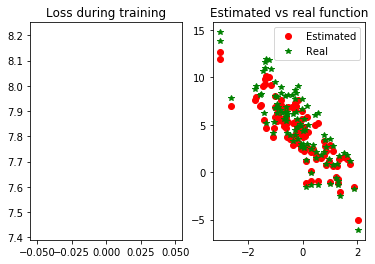

Epoch 1, batch 199. Moving avg of loss: 2.183198513510213. Average loss: 0.173495


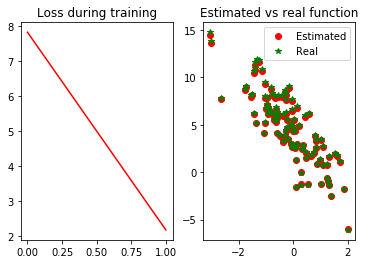

Epoch 2, batch 299. Moving avg of loss: 0.728725620589358. Average loss: 0.003231


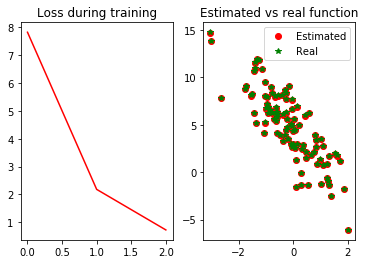

Epoch 3, batch 399. Moving avg of loss: 0.2583027306650774. Average loss: 0.000163


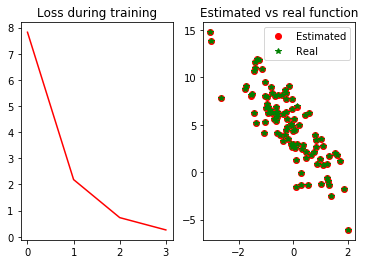

Epoch 4, batch 499. Moving avg of loss: 0.0935180810641564. Average loss: 0.000100


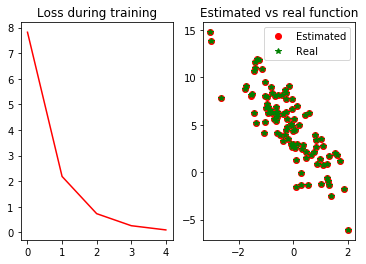

In [70]:
epochs = 5
learning_rate = 0.001
niter = 0
losses = []
moving_loss = 0
smoothing_constant = 0.01

# 训练
for e in range(epochs):
    total_loss = 0
    
    for data, label in data_iter():
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        SGD(params, learning_rate)
        total_loss += nd.sum(loss).asscalar()
        
        # 记录每读取一个数据点后，损失的移动平均值的变化；
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss
        
        # correct the bias from the moving averages
        est_loss = moving_loss/(1-(1-smoothing_constant)**niter)
        
        if (niter + 1) % 100 == 0:
            losses.append(est_loss)
            print("Epoch %s, batch %s. Moving avg of loss: %s. Average loss: %f" % (e, niter, est_loss, total_loss/num_examples))
            plot(losses, X)

In [71]:
true_w, w

([2, -3.4], 
 [[ 1.9998246]
  [-3.3995945]]
 <NDArray 2x1 @cpu(0)>)

In [72]:
true_b, b

(4.2, 
 [4.1996937]
 <NDArray 1 @cpu(0)>)